In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

### Get Data

In [6]:
df_train = pd.read_csv("Kannada-MNIST/train.csv")
df_test = pd.read_csv('Kannada-MNIST/Dig-MNIST.csv')

print(f"train.csv size is {df_train.shape}")
print(f"val_data size is {df_test.shape}")

train.csv size is (60000, 785)
val_data size is (10240, 785)


### Show Data

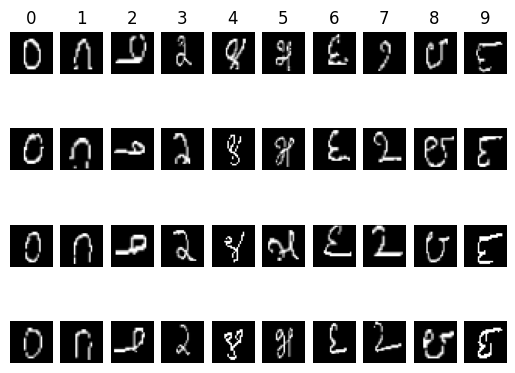

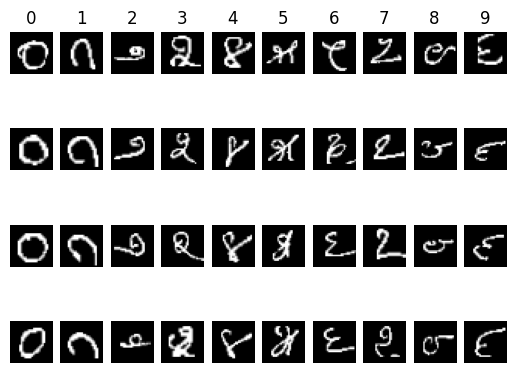

In [7]:
def show_imgs(x_train, y_train, rows=3):
    classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for y, cls in enumerate(classes):
        idxs = np.nonzero([i == y for i in y_train])
        idxs = np.random.choice(idxs[0], rows)
        for i , idx in enumerate(idxs):
            plt_idx = i * len(classes) + y + 1
            plt.subplot(rows, len(classes), plt_idx)
            plt.imshow(x_train.iloc[idx].values.reshape((28,28)), cmap='gray')
            plt.axis("off")
            if i == 0:
                plt.title(cls)
    plt.show()

# train.csv
show_imgs(df_train.iloc[:,1:], df_train.iloc[:,0], rows=4)

# Dig-MNIST.csv
show_imgs(df_test.iloc[:,1:], df_test.iloc[:,0], rows=4)


### Use PCA

In [8]:
x = df_train.iloc[:,1:]
y = df_train.iloc[:,0]

Text(0.5, 1.0, 'Visualizing Kannada MNIST through PCA')

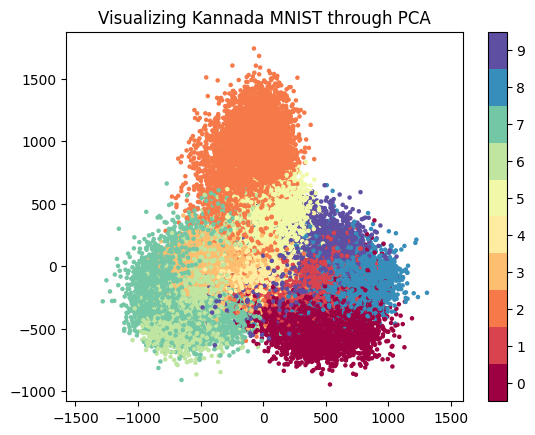

In [9]:
pca = PCA(n_components=2) # project from 784 to 2 dimensions
principalComponents = pca.fit_transform(x)

plt.scatter(principalComponents[:, 0], principalComponents[:, 1], s=5, c=y, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing Kannada MNIST through PCA')


### Split Dataset

In [ ]:
def one_hot(labels,Label_class):
    one_hot_label = np.array([[int(i == int(labels[j])) for i in range(Label_class)] for j in range(len(labels))])
    return one_hot_label
    
def data_prep(raw):
    # transform label to one-hot
    out_y = one_hot(raw.label, num_classes)
    # reshape pixels to image
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, img_rows, img_cols, 1)
    # normalization
    out_x = x_shaped_array / 255
    return out_x, out_y

def shuffle_data(x, y):
    indices = np.random.permutation(x.shape[0])
    return x[indices], y[indices] 

img_rows, img_cols = 28, 28
num_classes = 10

x_train, y_train = data_prep(df_train)
x_test, y_test = data_prep(df_test)

x_train, y_train = shuffle_data(x_train, y_train)
x_test, y_test = shuffle_data(x_test, y_test)


print(f"Train data size is {x_train.shape}")
print(f"Train data size is {y_train.shape}")
print(f"Test data size is {x_test.shape}")
print(f"Test data size is {y_test.shape}")


Training data size is (60000, 28, 28, 1)
Training data size is (60000, 10)
Validation data size is (10240, 28, 28, 1)
Validation data size is (10240, 10)


### SVM

#### Dimension Reduce

In [17]:
svm_x_train = x_train.reshape(x_train.shape[0],-1)
svm_x_test = x_test.reshape(x_test.shape[0],-1)

In [18]:
pca = PCA(n_components=0.7,whiten=True)
x_train_PCA = pca.fit_transform(svm_x_train)
x_test_PCA = pca.transform(svm_x_test)

### Train

In [19]:
svc_model = svm.SVC(kernel='rbf',C=10, gamma='auto')
_ = svc_model.fit(x_train_PCA, y_train.argmax(axis=1))

y_pred_sv = svc_model.predict(x_test_PCA)
sv_acc = accuracy_score(y_pred_sv, y_test.argmax(axis=1))
print('accuracy is', sv_acc)

accuracy is 0.71708984375


In [20]:
print(classification_report(y_test.argmax(axis=1), y_pred_sv))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1024
           1       0.91      0.66      0.77      1024
           2       0.72      0.86      0.79      1024
           3       0.81      0.53      0.64      1024
           4       0.87      0.67      0.76      1024
           5       0.59      0.92      0.72      1024
           6       0.60      0.66      0.63      1024
           7       0.84      0.60      0.70      1024
           8       0.63      0.85      0.73      1024
           9       0.78      0.84      0.81      1024

    accuracy                           0.72     10240
   macro avg       0.74      0.72      0.72     10240
weighted avg       0.74      0.72      0.72     10240



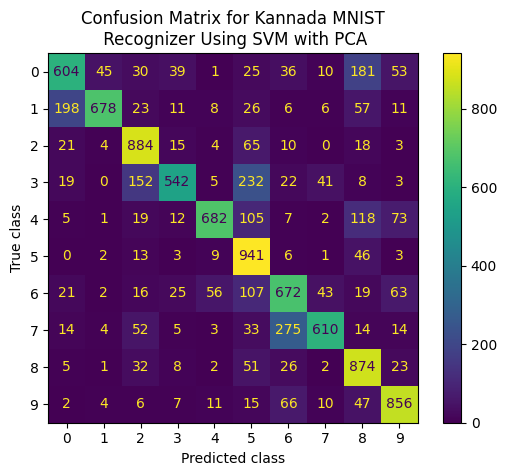

In [21]:
matrix_svm = confusion_matrix(y_test.argmax(axis=1), y_pred_sv)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_svm, display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for Kannada MNIST\n Recognizer Using SVM with PCA')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

### GridSearch

In [22]:
from sklearn.model_selection import GridSearchCV
 
param_grid = {
  'C': [0.1, 1, 10, 15, 20],
  'gamma': ['scale', 'auto'],
  'kernel': ['linear', 'rbf']  
}
 
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)  
 
grid_search.fit(x_train_PCA, y_train.argmax(axis=1))
 
print("Best parameters:", grid_search.best_params_)
 
best_model = grid_search.best_estimator_
 
y_pred_best = best_model.predict(x_test_PCA)
 
print("Accuracy after optimize:", accuracy_score(y_test.argmax(axis=1), y_pred_best))

Best parameters: {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy after optimize: 0.71787109375


### concatenate train and Dig-MNIST dataset

In [15]:
x_train, y_train = data_prep(df_train)
x_test, y_test = data_prep(df_test)
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((x_train, x_test)), 
                                                        np.concatenate((y_train, y_test)),
                                                        test_size=0.2, shuffle=True,
                                                        random_state=42, stratify=np.concatenate((y_train, y_test)))

print(f"Train data size is {x_train.shape}")
print(f"Train data size is {y_train.shape}")
print(f"Test data size is {x_test.shape}")
print(f"Test data size is {y_test.shape}")

Train data size is (56192, 28, 28, 1)
Train data size is (56192, 10)
Test data size is (14048, 28, 28, 1)
Test data size is (14048, 10)


In [18]:
svm_x_train = x_train.reshape(x_train.shape[0],-1)
svm_x_test = x_test.reshape(x_test.shape[0],-1)
pca = PCA(n_components=0.7,whiten=True)
x_train_PCA = pca.fit_transform(svm_x_train)
x_test_PCA = pca.transform(svm_x_test)

# train
svc_model = svm.SVC(kernel='rbf',C=15, gamma='scale')
_ = svc_model.fit(x_train_PCA, y_train.argmax(axis=1))

y_pred_sv = svc_model.predict(x_test_PCA)
sv_acc = accuracy_score(y_pred_sv, y_test.argmax(axis=1))
print('accuracy is', sv_acc)

accuracy is 0.9793564920273349


In [19]:
print(classification_report(y_test.argmax(axis=1), y_pred_sv))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1405
           1       0.98      0.98      0.98      1404
           2       0.99      0.98      0.99      1405
           3       0.98      0.98      0.98      1405
           4       0.99      0.99      0.99      1405
           5       0.99      0.99      0.99      1405
           6       0.96      0.97      0.96      1405
           7       0.97      0.97      0.97      1405
           8       0.99      0.99      0.99      1404
           9       0.99      0.98      0.99      1405

    accuracy                           0.98     14048
   macro avg       0.98      0.98      0.98     14048
weighted avg       0.98      0.98      0.98     14048



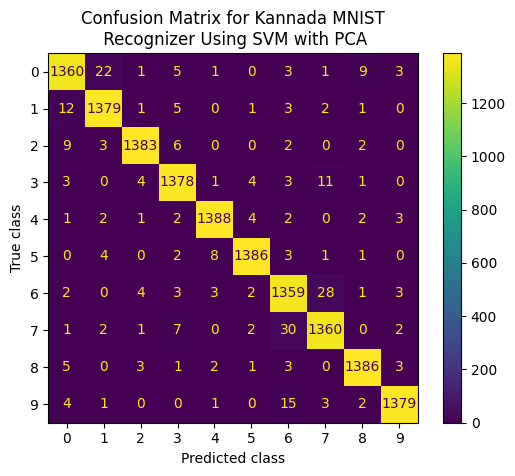

In [20]:
matrix_svm = confusion_matrix(y_test.argmax(axis=1), y_pred_sv)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix_svm, display_labels=np.unique(y))
disp.plot()
plt.title('Confusion Matrix for Kannada MNIST\n Recognizer Using SVM with PCA')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()